In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.data import Dataset
# from vae import VAE

In [2]:
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
from skimage.transform import resize
import os
from glob import glob
import os.path as path

In [3]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected as fc
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.elu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z


In [4]:
"""Define Dataset and global parameters"""
# data_root=path.expanduser('/home/aitrading/Desktop/GLTransform/output/npyface/')
data_root=path.expanduser('/home/aitrading/Desktop/GLTransform/output/npy128/')
np_files=glob(path.join(data_root,'*.npy'))  # list
mode = 'fully_connected'
# num_sample = 1400
# input_dim = 512*512
num_sample = 2800
input_dim = 128*128

def generate(batch_size):
    n=len(np_files)
    i=0
    while True:
        temp = []
        
        for j in range(batch_size):
            i+=1
            if i>=n:
                return
            temp.append(np.load(np_files[i]).reshape(-1))
        
        yield np.array(temp)
        

In [5]:
# if mode == 'fully_connected':
#     data_set = Dataset.from_generator(generate, (tf.int32, tf.int32))
# elif mode == 'CNN':
#     data_set = Dataset.from_generator(generate, (tf.int32, tf.int32), output_shapes = tf.TensorShape([512,512]))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [57]:
# def trainer(model_object, num_sample, input_dim, learning_rate=1e-4, batch_size=64, num_epoch=5, n_z=16, log_step=5, mode=mode):
#     model = model_object(mode= mode, input_dim=input_dim, learning_rate=learning_rate, batch_size=batch_size, no_z=n_z)

#     for epoch in range(num_epoch):
#         start_time = time.time()
#         for i in range(num_sample // batch_size):
#             # Get a batch

#             batch = next(generate())
#             print(batch.shape)
#             # Execute the forward and backward pass 
#             # Report computed losses
#             losses = model.run_single_step(batch)
#         end_time = time.time()
        
#         if epoch % log_step == 0:
#             log_str = '[Epoch {}] '.format(epoch)
#             for k, v in losses.items():
#                 log_str += '{}: {:.3f}  '.format(k, v)
#             log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
#             print(log_str)
            
#     print('Done!')
#     return model

In [6]:
# data_set = data_set.batch(32)
def trainer(model_object, learning_rate=1e-4, 
            batch_size=32, num_epoch=31, n_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = next(generate(batch_size))
#             batch = data_set.make_one_shot_iterator().get_next()
#             print(batch.shape)
    
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(batch)
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model


# Train a model
model = trainer(VariantionalAutoencoder)

/home/aitrading/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 529.980  latent_loss: 3.034  total_loss: 533.014  (0.735 sec/epoch)
[Epoch 5] recon_loss: 471.551  latent_loss: 9.796  total_loss: 481.347  (0.710 sec/epoch)
[Epoch 10] recon_loss: 461.234  latent_loss: 11.319  total_loss: 472.552  (0.707 sec/epoch)
[Epoch 15] recon_loss: 452.540  latent_loss: 11.732  total_loss: 464.272  (0.759 sec/epoch)
[Epoch 20] recon_loss: 445.654  latent_loss: 12.498  total_loss: 458.152  (0.702 sec/epoch)
[Epoch 25] recon_loss: 442.938  latent_loss: 12.629  total_loss: 455.566  (0.701 sec/epoch)
[Epoch 30] recon_loss: 438.819  latent_loss: 12.480  total_loss: 451.299  (0.723 sec/epoch)
Done!


In [48]:
# model = trainer(VAE,num_sample,input_dim)

num_sample // batch_size 21
[Epoch 0] recon_loss: -inf  latent_loss: nan  total_loss: nan  (0.587 sec/epoch)
num_sample // batch_size 21
num_sample // batch_size 21
num_sample // batch_size 21
num_sample // batch_size 21
Done!


In [14]:
def test_reconstruction(model, data_set, h=28, w=28, batch_size=16):
    # Test the trained model: reconstruction
    batch = next(data_set(batch_size))
    x_reconstructed = model.reconstructor(batch)

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

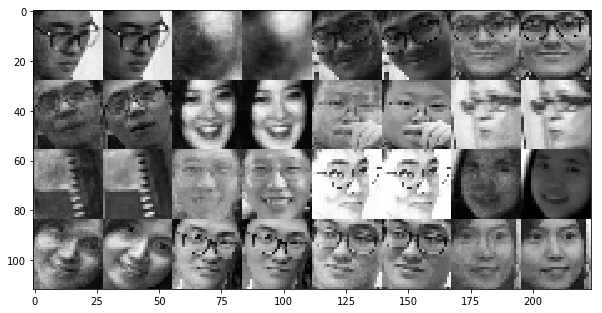

In [15]:
test_reconstruction(model, generate)

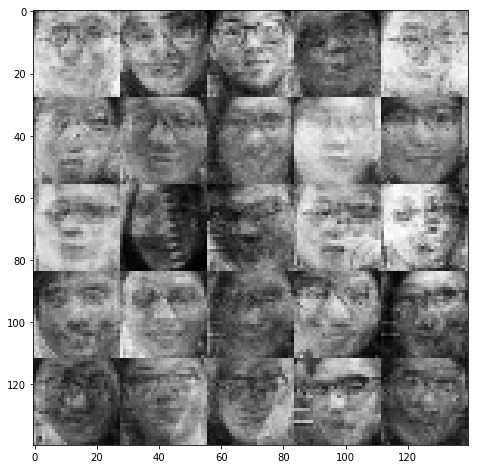

In [17]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
h=28
w=28
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')